### The purpose of this notebook is to time series forecasting and clustering
 - also making utility functions into a module
 

In [3]:
import basket_util

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
import collections

import plotly as py
import plotly.express as px
import plotly.offline as pyo
from plotly.offline import iplot, plot, init_notebook_mode, download_plotlyjs
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from pySankey.sankey import sankey

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

import warnings
warnings.filterwarnings('ignore')


 - first, prepare the data

In [133]:
from math import floor
def prep_data(filename, dropna,datecol):
    baskets = pd.read_csv(filename, parse_dates = [datecol])
    if dropna:
        baskets.dropna(inplace=True)
    for s in baskets.columns:
        if ("id" in s):
            baskets.loc[:,s] = baskets.loc[:,s].astype(int)
            #baskets.loc[:,s] = pd.Categorical(baskets.loc[:,s].apply(lambda x: floor(x))) 
            # -- making them into categorical has undesirable effect
    if datecol:
        baskets['date'] = baskets[datecol].dt.date
        baskets['year'] = baskets[datecol].dt.year
        baskets['month'] = baskets[datecol].dt.month
        baskets['month1'] = baskets[datecol].apply(lambda t: t.strftime("%Y-%m"))
        baskets['month_num'] = (baskets['year'] - 2021) * 12 + baskets['month']
        baskets['week_num'] = baskets[datecol].dt.isocalendar().week
        baskets['week_num'] = (baskets['year'] - 2021) * 52 + baskets['week_num']
        baskets['week1'] = baskets[datecol].apply(lambda t: t.strftime("%Y-%W")) # this makes the beginning of Jan 2022 as week 2022-00 , not 2022-52
        baskets.loc[baskets['week_num']==104,'week_num'] = 52
        baskets['day'] = baskets[datecol].dt.day
        baskets['hour'] = baskets[datecol].dt.hour
        baskets['weekday'] = baskets[datecol].dt.weekday
        baskets["spent"] = baskets["qty"] * baskets["price"]
    return baskets

def make_merchants(baskets):
    merchants = baskets.groupby(['merchant_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        first_month = ('month_num', 'min'), 
        last_month = ('month_num', 'max'), 
        num_months = ('month_num', 'nunique'), 
        num_weeks = ('week_num', 'nunique'), 
        num_days = ('date', 'nunique'), 
        num_skus = ('sku_id','nunique'), 
        num_top_cats = ('top_cat_id','nunique'), 
        num_sub_cats = ('sub_cat_id','nunique'),
    ).reset_index()
    merchants['avg_spent_per_order'] = merchants.total_spent / merchants.num_orders
    merchants['tenure_month'] = merchants.last_month - merchants.first_month +1
    return merchants

def get_order_attributes(baskets):
    order_attributes = baskets.groupby(['order_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_skus = ('sku_id','nunique'), 
        num_top_cats = ('top_cat_id','nunique'), 
        num_sub_cats = ('sub_cat_id','nunique'),
    ).reset_index()
    return order_attributes

def get_sku_attributes(baskets):
    skus = baskets.groupby(['sku_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        num_merchants = ('merchant_id', 'nunique'), 
        first_month = ('month_num', 'min'), 
        last_month = ('month_num', 'max'), 
        num_months = ('month_num', 'nunique'), 
        first_week = ('week_num', 'min'), 
        last_week = ('week_num', 'max'), 
        num_weeks = ('week_num', 'nunique'), 
        num_days = ('date', 'nunique'), 
    ).reset_index()
    skus['avg_spent_per_order'] = skus.total_spent / skus.num_orders
    skus['tenure_month'] = skus.last_month - skus.first_month +1
    return skus

def get_skus_by_day(baskets):
    skus_by_day = baskets.groupby(['sku_id','date']).agg(
        avg_price_by_day = ('price','mean'),
        num_order_by_day = ('order_id', 'nunique'), 
        num_merchants_by_day = ('merchant_id', 'nunique'),
    ).reset_index()
    return skus_by_day

def make_top_cats(baskets):
    top_cats = baskets.groupby(['top_cat_id']).agg(
        avg_price = ('price', 'mean'),
        total_spent = ('spent', 'sum'),
        total_quantity = ('qty' , 'sum'),
        num_orders = ('order_id', 'nunique'), 
        num_days = ('date' , 'nunique'),
        num_merchants = ('merchant_id', 'nunique')
    ).reset_index()
    return top_cats


In [134]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = [] # wcss: Within Cluster Sum of Squares
    for k in clusters_range:
        kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)
    plt.figure()
    plt.plot(clusters_range,inertias, marker='o')
    plt.title('Elbow method for deciding on k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('inertia')
    plt.show()
    return
    
def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    return df

In [155]:
dropna = True
datecol = 'placed_at'
#filename = 'new_baskets_full.csv'
filename = 'new_baskets_adhie.csv'
#filename = 'offload_adhie_transaction_dataset_to_sep_22_forecasting_dataset_adhie_capstone_project.csv_as_is.csv'


baskets = prep_data(filename, dropna,datecol)
merchants = make_merchants(baskets)
sku_attributes = get_sku_attributes(baskets)
order_attributes = get_order_attributes(baskets)

sku_by_day = get_skus_by_day(baskets)
top_cats = make_top_cats(baskets)

In [156]:
baskets = baskets[baskets.merchant_id !=190]
baskets = baskets[baskets.merchant_id !=12]
baskets = baskets[baskets.merchant_id !=206]

In [157]:
baskets = baskets[baskets.date >=  pd.to_datetime('2021-09-27').date()]
df1 = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values='order_id', # Column to aggregate for values
    aggfunc="nunique")    # Aggregation function
df2 = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values='spent', # Column to aggregate for values
    aggfunc="sum")    # Aggregation function
df1.fillna(0,inplace=True)
df2.fillna(0,inplace=True)

In [158]:
df2.head()

top_cat_id,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,32,33,34,35
merchant_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,592000.0,...,47000.0,8339900.0,0.0,216000.0,0.0,0.0,171000.0,0.0,147000.0,0.0
2,90000.0,0.0,0.0,0.0,916000.0,0.0,0.0,0.0,0.0,365500.0,...,397000.0,10004500.0,55000.0,245500.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,51000.0,0.0,1024000.0,0.0,0.0,215000.0,11500.0,1144500.0,...,206000.0,27497700.0,0.0,349000.0,0.0,84000.0,20000.0,105000.0,592000.0,471000.0
4,0.0,0.0,0.0,65000.0,115000.0,0.0,0.0,0.0,0.0,603000.0,...,0.0,0.0,0.0,51000.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,255000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1779500.0,0.0,240000.0,0.0,0.0,0.0,0.0,0.0,0.0


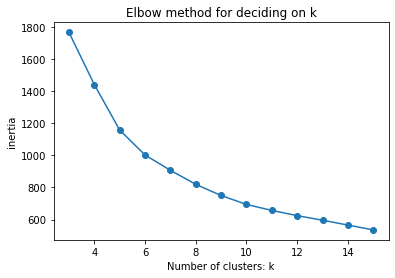

In [146]:
colnames = df1.columns
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df1, colnames,clusters_range)

In [159]:
k = 6
df1_kmeans = run_kmeans(df1, colnames,k)
df1_kmeans.groupby("cluster").size()

cluster
0     53
1    178
2      8
3     16
4      4
5     66
dtype: int64

In [160]:
(df1.query('cluster ==4'))

top_cat_id,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,cluster
merchant_id,,,,,,,,,,,,,,,,,,,,,
11,1.0,1.0,2.0,2.0,26.0,0.0,1.0,0.0,2.0,46.0,...,162.0,0.0,10.0,3.0,4.0,17.0,0.0,21.0,10.0,4
36,1.0,0.0,3.0,1.0,58.0,0.0,1.0,1.0,2.0,50.0,...,125.0,3.0,22.0,0.0,1.0,30.0,1.0,17.0,11.0,4
53,2.0,0.0,2.0,5.0,58.0,0.0,1.0,0.0,2.0,25.0,...,95.0,8.0,38.0,7.0,1.0,14.0,1.0,19.0,17.0,4
115,6.0,0.0,0.0,10.0,27.0,0.0,1.0,6.0,1.0,18.0,...,47.0,1.0,9.0,0.0,2.0,9.0,2.0,7.0,4.0,4


In [153]:
colnames = df2.columns
k = 6
df2_kmeans = run_kmeans(df2, colnames,k)
df2_kmeans.groupby("cluster").size()


cluster
0    293
1      1
2      6
3     20
4      1
5      7
dtype: int64

In [154]:
(df2.query('cluster ==1 or cluster==4'))

top_cat_id,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,cluster
merchant_id,,,,,,,,,,,,,,,,,,,,,
12,0.0,0.0,0.0,321000.0,3230000.0,0.0,242000.0,0.0,0.0,5205000.0,...,1.425743e+08,91000.0,1186000.0,0.0,0.0,565000.0,0.0,858000.0,465000.0,4
190,26582000.0,1448600.0,2769000.0,35929500.0,588908700.0,0.0,0.0,2586000.0,4932500.0,520799000.0,...,9.743233e+09,21281000.0,152442000.0,6043000.0,11465500.0,52169500.0,5666000.0,155507600.0,24286100.0,1


In [115]:
df2 = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values='qty', # Column to aggregate for values
    aggfunc="sum")    # Aggregation function
df2.fillna(0,inplace=True)
df2.drop(labels=27, axis=1,  inplace=True, errors='raise')

In [52]:
baskets = baskets[baskets.merchant_id !=190]
baskets = baskets[baskets.merchant_id !=12]
baskets = baskets[baskets.merchant_id !=206]


In [87]:
df2_kmeans.isnull().sum()

top_cat_id
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
27         0
28         0
29         0
30         0
31         0
32         0
33         0
34         0
35         0
cluster    0
dtype: int64

In [76]:
df2_kmeans = df2_kmeans.reset_index()

In [88]:
df2_kmeans.groupby(by="top_cat_id").mean()

KeyError: 'top_cat_id'

In [65]:
df2[df2["cluster"]==2]

top_cat_id,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,cluster
merchant_id,,,,,,,,,,,,,,,,,,,,,
51,1537000.0,510000.0,1271000.0,4596000.0,123442100.0,0.0,62000.0,0.0,350000.0,112835000.0,...,875467900.0,2040000.0,23697000.0,1598000.0,993000.0,11291000.0,0.0,46006500.0,4462300.0,2


/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



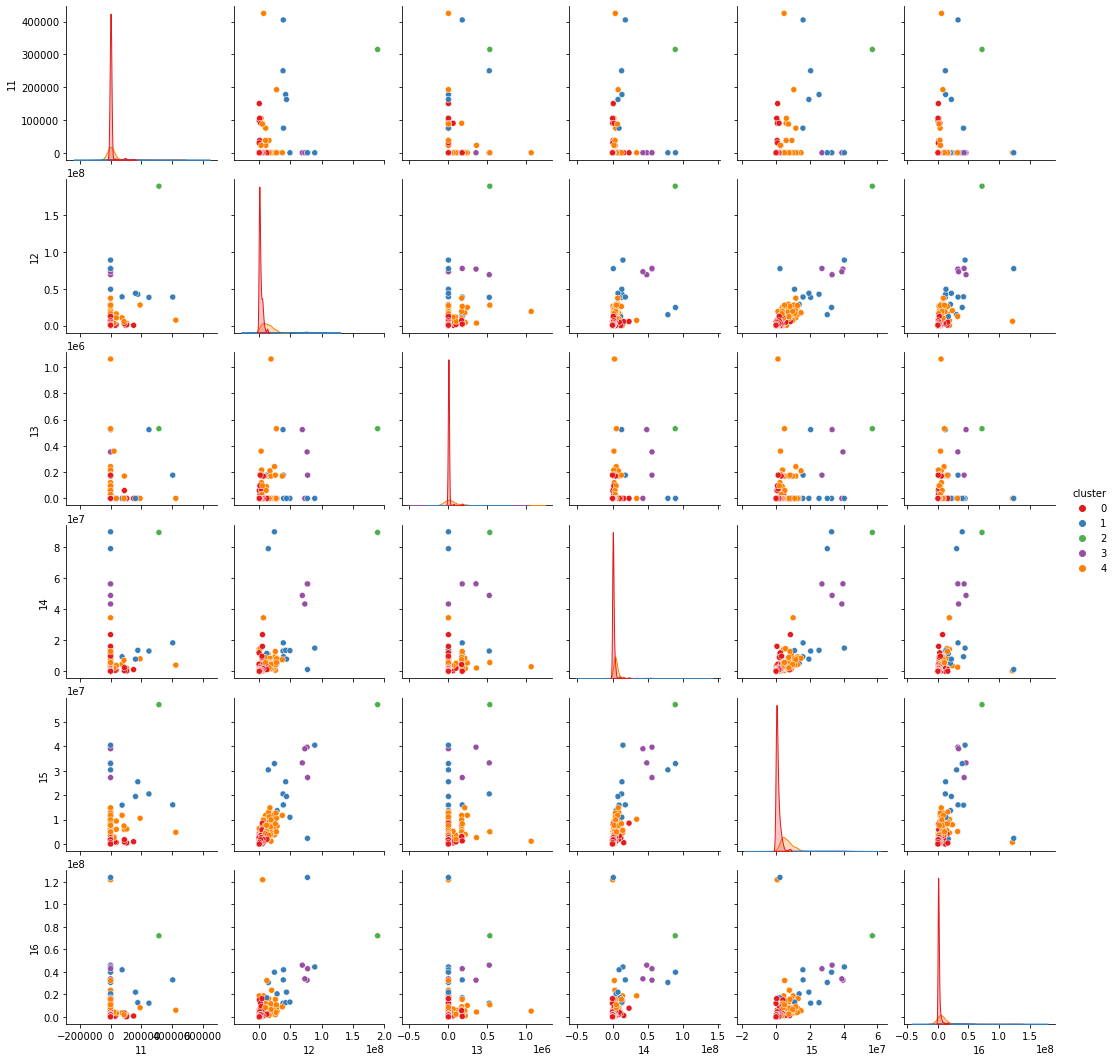

In [67]:
sns.pairplot(data=df2_kmeans[["cluster",11,12,13,14,15,16]], hue="cluster", palette="Set1")


In [9]:
baskets.placed_at.apply(lambda t: t.strftime("%Y-%W"))

0         2021-24
1         2021-24
2         2021-24
3         2021-24
4         2021-24
           ...   
392936    2022-39
392937    2022-39
392938    2022-39
392939    2022-39
392940    2022-39
Name: placed_at, Length: 392810, dtype: object

In [10]:
baskets[baskets.month1 == "2022-01"]

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,month1,month_num,week_num,week1,day,hour,weekday,spent
118551,118577,11166,2022-01-02 08:41:25.676,190,891,5,86,3,31500.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,94500.0
118552,118578,11166,2022-01-02 08:41:25.676,190,963,27,86,1,369000.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,369000.0
118553,118579,11166,2022-01-02 08:41:25.676,190,1207,27,86,3,30000.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,90000.0
118554,118580,11166,2022-01-02 08:41:25.676,190,866,27,86,1,160500.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,160500.0
118555,118581,11166,2022-01-02 08:41:25.676,190,1488,27,86,1,239000.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,239000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150087,150095,14159,2022-01-31 17:05:15.920,125,866,27,86,1,163000.0,2022-01-31,2022,1,2022-01,13,57,2022-05,31,17,0,163000.0
150088,150096,14159,2022-01-31 17:05:15.920,125,962,27,86,10,18700.0,2022-01-31,2022,1,2022-01,13,57,2022-05,31,17,0,187000.0
150089,150097,14159,2022-01-31 17:05:15.920,125,983,27,86,1,250000.0,2022-01-31,2022,1,2022-01,13,57,2022-05,31,17,0,250000.0
150090,150098,14159,2022-01-31 17:05:15.920,125,1488,27,86,1,240500.0,2022-01-31,2022,1,2022-01,13,57,2022-05,31,17,0,240500.0


<AxesSubplot:xlabel='num_skus', ylabel='Density'>

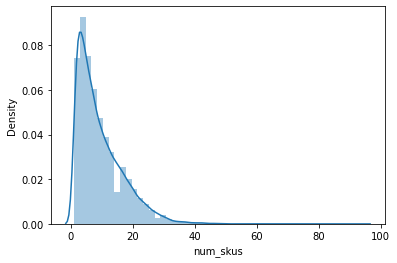

In [11]:
sns.distplot(order_attributes.num_skus)


In [81]:
(order_attributes.num_skus==1).sum()/order_attributes.shape[0]

0.04631923234169452

In [72]:
((order_attributes.total_spent.apply(lambda x: math.log(x,2))>25) | \
(order_attributes.total_spent.apply(lambda x: math.log(x,2))<15) ).sum()/order_attributes.shape[0]

0.0024530434573483083

In [73]:
order_attributes[(order_attributes.total_spent.apply(lambda x: math.log(x,2))>25) | \
(order_attributes.total_spent.apply(lambda x: math.log(x,2))<15)].head(100)

,order_id,total_spent,num_skus,num_top_cats,num_sub_cats
189,190,16100.0,1,1,1
430,431,17700.0,1,1,1
696,697,17800.0,1,1,1
723,724,17800.0,1,1,1
758,759,32000.0,1,1,1
...,...,...,...,...,...
39376,39379,16500.0,1,1,1
40129,40132,24000.0,1,1,1
40282,40285,47647000.0,14,5,3
40501,40504,32000.0,1,1,1


In [ ]:
order_attributes[(order_attributes.total_spent.apply(lambda x: math.log(x,2))>25) | \
(order_attributes.total_spent.apply(lambda x: math.log(x,2))<15)].head(100)

In [45]:
392810/41581

9.446862749813617

In [94]:
pd.set_option('display.max_rows', 100)
print(baskets.groupby("week_num").merchant_id.nunique())

week_num
24     11
25      4
26      8
27      8
28      4
29      3
30      2
31      3
32      3
33      2
34      2
35      3
36      2
37      2
38      2
39    112
40    165
41    153
42    139
43    137
44    140
45    147
46    130
47    123
48    132
49    138
50    142
51    135
52    135
53    150
54    157
55    146
56    147
57    152
58    159
59    142
60    148
61    146
62    148
63    138
64    146
65    155
66    137
67    131
68    151
69    122
70     61
71    133
72    141
73    137
74    147
75    131
76    136
77    134
78    149
79    131
80    142
81    138
82    138
83    134
84    140
85    148
86    147
87    144
88    138
89    140
90    154
91    136
Name: merchant_id, dtype: int64


In [127]:
baskets[baskets["week_num"] < 39].groupby("merchant_id").nunique()

,id,order_id,placed_at,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,month_num,week_num,day,hour,weekday,spent
merchant_id,,,,,,,,,,,,,,,,,
9,4,1,1,4,1,1,2,4,1,1,1,1,1,1,1,1,4
10,2,1,1,2,1,1,1,2,1,1,1,1,1,1,1,1,2
11,27494,3035,3035,634,33,80,64,542,93,1,4,4,15,31,11,7,1008
12,310,15,15,122,22,36,37,133,10,1,2,2,4,10,4,6,183
13,2,2,2,1,1,1,1,2,1,1,1,1,1,1,1,1,2
14,99,8,8,69,13,22,21,73,8,1,2,2,4,8,2,6,74
15,61,4,4,56,11,19,19,55,4,1,2,2,4,4,2,3,55
16,2,1,1,2,1,1,1,2,1,1,1,1,1,1,1,1,2
17,9,1,1,9,2,2,1,9,1,1,1,1,1,1,1,1,9


for weekly analysis, to make the work meaningful, we should use data from week 39 and onwards
for monthly analysis, to make the work meaningful, we should use the data from month October 2021 to Sepetember 2022.

In [83]:
sku_attributes.groupby("tenure_month").count()

,sku_id,total_spent,num_orders,num_merchants,first_month,last_month,num_months,num_weeks,num_days,avg_spent_per_order
tenure_month,,,,,,,,,,
1,55,55,55,55,55,55,55,55,55,55
2,55,55,55,55,55,55,55,55,55,55
3,51,51,51,51,51,51,51,51,51,51
4,172,172,172,172,172,172,172,172,172,172
5,416,416,416,416,416,416,416,416,416,416
6,19,19,19,19,19,19,19,19,19,19
7,27,27,27,27,27,27,27,27,27,27
8,27,27,27,27,27,27,27,27,27,27
9,36,36,36,36,36,36,36,36,36,36


In [101]:
sku_attributes.shape

(1800, 13)

In [102]:
print(sku_attributes.groupby("first_week").sku_id.nunique())

first_week
24     29
25    292
26    206
27     23
28     30
29      7
30     10
31      6
32      5
33      2
34      4
35      4
36      1
37     14
38      3
39      5
40     10
41    503
42    293
43    108
44     44
45     28
46     14
47     17
48     14
49     12
50      5
51      6
52      7
53      4
54      6
55      8
56      5
57      1
58      2
59      1
60      6
61      5
62      2
63      5
64      3
66      5
67      2
68      2
69      1
71      5
72      1
73      2
74      1
75      1
76      3
77      4
78      9
79      4
80      2
81      1
82      1
83      2
84      3
87      1
Name: sku_id, dtype: int64


In [108]:
fig = px.parallel_coordinates(sku_attributes[["first_month","sku_id","last_month","tenure_month"]], \
        color="tenure_month", labels={"sku_id": "sku ID",
                "first_month": "First Month", "last_month": "Last Month", },)
                             #color_continuous_scale=px.colors.diverging.Tealrose,
                            # color_continuous_midpoint=2)
fig.show()

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



<Figure size 6000x3000 with 0 Axes>

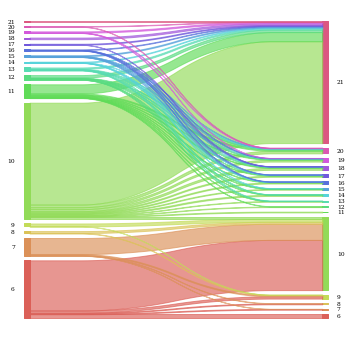

In [121]:
plt.figure(figsize=(30, 15), dpi=200)
df = sku_attributes.groupby(["first_month","last_month"]).sku_id.nunique().reset_index()
sankey(
    left=df["first_month"], right=df["last_month"],
    leftWeight= df["sku_id"], rightWeight=df["sku_id"], 
    aspect=20, fontsize=6
)

In [131]:
fig = px.parallel_coordinates(merchants[["first_month","merchant_id","last_month","tenure_month"]], \
        color="tenure_month", labels={"merchant_id": "merchant ID",
                "first_month": "First Month", "last_month": "Last Month", },)
                             #color_continuous_scale=px.colors.diverging.Tealrose,
                            # color_continuous_midpoint=2)
fig.show()

In [132]:
merchants[merchants.merchant_id==11]

,merchant_id,total_spent,num_orders,first_month,last_month,num_months,num_weeks,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,tenure_month
10,11,3.553156e+09,3236,6,20,7,21,117,663,33,81,1.098009e+06,15


In [135]:
(baskets.query('merchant_id ==11').query('month_num == 20'))


,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,month_num,week_num,day,hour,weekday,spent
350144,350165,36455,2022-08-22 13:44:40.652,11,1133,16,50,1,55000.0,2022-08-22,2022,8,20,86,22,13,0,55000.0
350145,350166,36455,2022-08-22 13:44:40.652,11,920,16,86,1,59500.0,2022-08-22,2022,8,20,86,22,13,0,59500.0


In [ ]:
1133 => 967056
920 ==>966689

<Figure size 6000x3000 with 0 Axes>

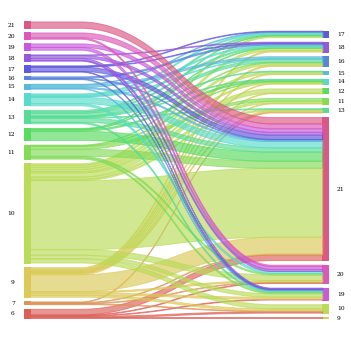

In [129]:
plt.figure(figsize=(30, 15), dpi=200)
df = merchants.groupby(["first_month","last_month"]).merchant_id.nunique().reset_index()
sankey(
    left=df["first_month"], right=df["last_month"],
    leftWeight= df["merchant_id"], rightWeight=df["merchant_id"], 
    aspect=20, fontsize=6
)

<AxesSubplot:>

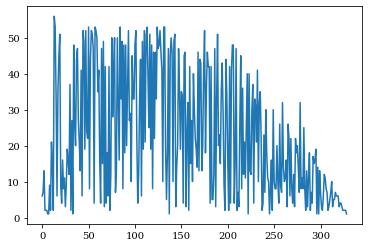

In [140]:
merchants.num_weeks.plot()

In [19]:
def count_unique(s):
    return len(s.unique())

sku_frequency = (baskets
    .groupby('sku_id')
    ['order_id']
 .agg(count_unique) # aggregate using the custom count_unique function
 .reset_index()
)


In [42]:
sku_frequency.head()
px.line(sku_attributes.num_orders)

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [34]:
sum(sku_frequency.order_id>50)

892

In [30]:
px.line(sku_frequency.sort_values("order_id", ascending = False).reset_index().order_id)


/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [13]:
px.line(sku_frequency, x='',y='order_id',width=800,height=300)

TypeError: 'module' object is not callable

In [9]:
sku_frequency.sort_values("order_id",ascending=False)

,sku_id,order_id
1487,1488,11847
858,859,8948
1496,1497,8267
865,866,7672
975,976,7466
...,...,...
914,915,3
1730,1731,3
664,665,3
0,1,3


<AxesSubplot:>

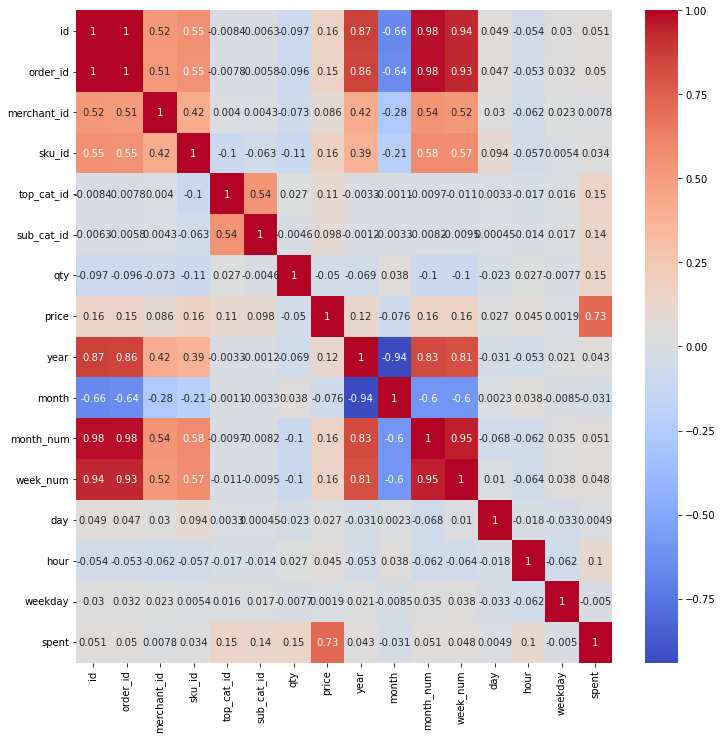

In [50]:
plt.figure(figsize=(12,12)) 
sns.heatmap(baskets.corr(),annot=True, cmap='coolwarm')

In [65]:
px.line(pd.crosstab(baskets['week_num'], baskets['top_cat_id']),width=800,height=800)

In [48]:
df = baskets
df.groupby('order_id').all()

,id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,month_num,week_num,day,hour,weekday,spent
order_id,,,,,,,,,,,,,,,,,
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22804,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
22805,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
22806,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [49]:
transaction_data = []
for groups in df.groupby('order_id').groups.values():
    transaction_data.append(list(df.loc[groups]['sku_id'].to_numpy()))

In [66]:
transaction_data[0]

[470,
 237,
 236,
 238,
 547,
 253,
 355,
 1354,
 281,
 425,
 204,
 1367,
 570,
 276,
 269,
 271,
 569,
 493,
 404,
 235,
 1558,
 1300,
 299,
 438,
 589,
 435,
 432,
 1545,
 460,
 1544,
 481,
 485,
 762,
 327,
 267,
 336,
 184,
 337,
 710,
 717,
 501,
 1577,
 1335,
 262]

In [52]:
def oneHotCoding(transaction_data):
    te = TransactionEncoder()
    te_ary = te.fit(transaction_data).transform(transaction_data)
    transaction_df = pd.DataFrame(te_ary, columns=te.columns_)
    return transaction_df

transaction_sku_data = oneHotCoding(transaction_data)

In [65]:
transaction_sku_data[1]

0        False
1        False
2        False
3        False
4        False
         ...  
62042    False
62043    False
62044    False
62045    False
62046    False
Name: 1, Length: 62047, dtype: bool

In [54]:
def frq_sku_itemsets(data,suppVar):
    min_support = suppVar/data.shape[0]
    frequent_itemsets = fpgrowth(data, min_support=min_support, use_colnames=True)
    return frequent_itemsets

freq_itemsets = frq_sku_itemsets(transaction_sku_data,30)

In [55]:
freq_itemsets.head(50)

,support,itemsets
0,0.120860,(327)
1,0.090077,(438)
2,0.059906,(276)
3,0.056054,(184)
4,0.055313,(432)
5,0.052476,(485)
6,0.051590,(336)
7,0.049463,(547)
8,0.042307,(337)
9,0.041549,(1300)


In [56]:
# compute and print the association rules

def basket_rules(freq_itemsets,metrics,threshold):
    asso_rules = association_rules(freq_itemsets, metric=metrics, min_threshold=threshold)
    return asso_rules.sort_values(by='lift', ascending=False)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

fp_rules = basket_rules(freq_itemsets,"confidence",0.10)
fp_rules.head(60)

,antecedents,consequents,support,confidence,lift
884882,(1245),(1244),0.000564,0.564516,875.663306
884881,(1244),(1245),0.000564,0.875000,875.663306
872749,"(432, 858)","(859, 435)",0.000484,0.491803,726.545667
872746,"(859, 435)","(432, 858)",0.000484,0.714286,726.545667
872747,"(432, 859)","(858, 435)",0.000484,0.454545,705.079545
872748,"(858, 435)","(432, 859)",0.000484,0.750000,705.079545
884369,"(1105, 1107)",(1106),0.000548,0.944444,681.394703
884372,(1106),"(1105, 1107)",0.000548,0.395349,681.394703
881905,"(977, 978)","(976, 975)",0.000548,0.723404,669.926326
881904,"(976, 975)","(977, 978)",0.000548,0.507463,669.926326


In [57]:
fp_rules

,antecedents,consequents,support,confidence,lift
884882,(1245),(1244),0.000564,0.564516,875.663306
884881,(1244),(1245),0.000564,0.875000,875.663306
872749,"(432, 858)","(859, 435)",0.000484,0.491803,726.545667
872746,"(859, 435)","(432, 858)",0.000484,0.714286,726.545667
872747,"(432, 859)","(858, 435)",0.000484,0.454545,705.079545
...,...,...,...,...,...
683866,(283),(327),0.000967,0.111524,0.922755
683868,"(282, 283)",(327),0.000532,0.104762,0.866804
866618,(626),(327),0.000580,0.104651,0.865888
793910,"(419, 420)",(327),0.001451,0.103093,0.852993


In [58]:
def predict(antecedent, rules, max_results= 6):
    
    # get the rules for this antecedent
    preds = rules[rules['antecedents'] == antecedent]
    
    # a way to convert a frozen set with one element to string
    preds = preds['consequents'].apply(iter).apply(next)
    
    return preds[:max_results]

In [67]:
preds = predict({859, 435}, fp_rules)
preds

872746    432
872739    858
872384    432
Name: consequents, dtype: int64

In [60]:
fp_rules.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885767 entries, 884882 to 793902
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   antecedents  885767 non-null  object 
 1   consequents  885767 non-null  object 
 2   support      885767 non-null  float64
 3   confidence   885767 non-null  float64
 4   lift         885767 non-null  float64
dtypes: float64(3), object(2)
memory usage: 40.5+ MB
